[[ -59.  -58.  -57. ...  938.  939.  940.]
 [ -56.  -55.  -54. ...  941.  942.  943.]
 [   3.    4.    5. ... 1000. 1001. 1002.]
 ...
 [ -48.  -47.  -46. ...  949.  950.  951.]
 [  19.   20.   21. ... 1016. 1017. 1018.]
 [  76.   77.   78. ... 1073. 1074. 1075.]]
[[-0.1904226  -0.23924923 -0.2874781  ...  0.22202252  0.17301404
   0.12357312]
 [-0.3349882  -0.381661   -0.42737985 ...  0.07382335  0.02388906
  -0.02610875]
 [ 0.14943814  0.19866933  0.24740396 ... -0.26237485 -0.2138195
  -0.16472971]
 ...
 [-0.67546314 -0.7114734  -0.74570525 ... -0.32036138 -0.36730534
  -0.41333127]
 [ 0.8134155   0.841471    0.86742324 ...  0.5094253   0.5517958
   0.59279025]
 [-0.61185783 -0.65062505 -0.6877662  ... -0.24054414 -0.2887545
  -0.33624312]]


AttributeError: cannot assign module before Module.__init__() call

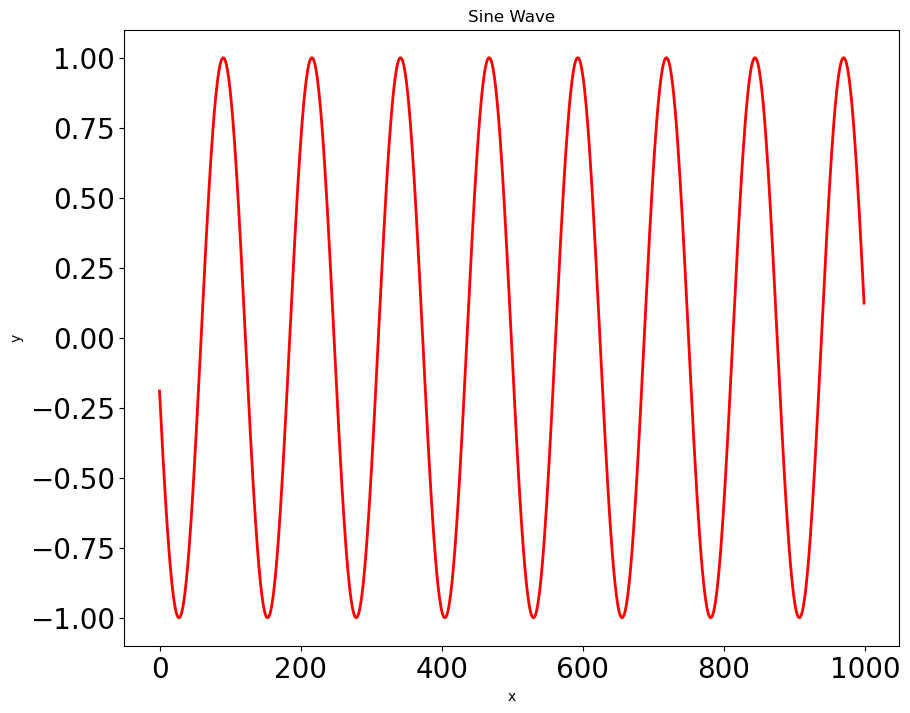

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt

N=100
L=1000
T=20

x=np.empty((N,L),np.float32)
x[:]=np.array(range(L))+np.random.randint(-4*T,4*T,N).reshape(N,1)
print(x)
y=np.sin(x/1.0/T).astype(np.float32)
print(y)
plt.figure(figsize=(10,8))
plt.title("Sine Wave")
plt.xlabel("x")
plt.ylabel("y")
plt.xticks(fontsize=20)
plt.yticks(fontsize=20)
plt.plot(np.arange(x.shape[1]),y[0,:],'r',linewidth=2.0)
plt.show

class LSTMPredictor(nn.Module):
    def __init__(self,n_hidden=51):
        super(LSTMPredictor,self).__init__
        self.n_hidden=n_hidden
        self.lstm1=nn.LSTMCell(1,self.n_hidden)
        self.lstm2=nn.LSTMCell(self.n_hidden,self.n_hidden)
        self.linear=nn.Linear(self.n_hidden,1)

    def forward(self,x,future=0):
        outputs=[]
        n_samples=x.size(0)
        h_t=torch.zeros(n_samples,self.n_hidden, dtype=torch.float32)
        c_t=torch.zeros(n_samples,self.n_hidden, dtype=torch.float32)
        
        h_t2=torch.zeros(n_samples,self.n_hidden, dtype=torch.float32)
        c_t2=torch.zeros(n_samples,self.n_hidden, dtype=torch.float32)

        for input_t in x.split(1,dim=1):
            h_t,c_t=self.lstm1(input_t,(h_t,c_t))
            h_t2,c_t2=self.lstm1(h_t,(h_t2,c_t2))
            output=self.linear(h_t2)
            outputs.append(output)
        for i in range(future):
            h_t,c_t=self.lstm1(output,(h_t,c_t))
            h_t2,c_t2=self.lstm1(h_t,(h_t2,c_t2))
            output=self.linear(h_t2)
            outputs.append(output)

        outputs=torch.cat(outputs, dim=1)
        return outputs

if __name__=="__main__":
    train_input=torch.from_numpy(y[3:,:-1])
    train_target=torch.from_numpy(y[3:,1:])
    test_input=torch.from_numpy(y[:3,:-1])
    test_target=torch.from_numpy(y[:3,1:])

    model=LSTMPredictor()
    criterion=nn.MSELoss()

    optimizer=optim.LBFGS(model.parameters(),lr=0.8)

    n_steps=10
    for i in range(n_steps):
        print("Steps",i)
        
        def closure():
            optimizer.zero_grad()
            out = model(train_input)
    
    # Adjust train_target to match out[:, :-1] shape
            target_slice = train_target[:, :out.size(1)]  # Slice train_target to match out's sequence length
    
            loss = criterion(out[:, :-1].squeeze(), target_slice.squeeze())
            print("Loss:", loss.item())
            loss.backward()
            return loss

        optimizer.step(closure)

        with torch.no_grad():
            future=1000
            pred=model(test_input,future=future)
            loss=criterion(pred[:,:-future], test_target)
            print("test loss",loss.item())
            y=pred.detach().numpy()
        
        plt.figure(figsize=(12,6))
        plt.title(f"step{i+1}")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.xticks(fontsize=20)
        plt.yticks(fontsize=20)
        n=train_input.shape[1]
        def draw(y_i,color):
            plt.plot(np. arange(n), y_i[:n], color, linewidth=2.0)
            plt.plot(np. arange(n,n+future), y_i[n:], color+":", linewidth=2.0)
        draw(y[0],'r')
        draw(y[1],'b')
        draw(y[2],'g')

        plt.savefig("predict%d.pdf"%i)
        plt.close()
